In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from collections import Counter


## Primero definiremos algunas funciones que usaremos por todo el codigo 


Crea un mapa de calor entre dos parámetros con el rendimiento de cada combinacón dada 

In [2]:
def param_heat(results, param_grid, param_x, param_y):

    param_x_r = param_grid[param_x]
    param_y_r = param_grid[param_y]
    scores = results['mean_test_f1'].values.reshape(len(param_y_r), len(param_x_r))

    plt.figure(figsize=(8, 6))
    sns.heatmap(scores, annot=True, xticklabels=param_x_r, yticklabels=param_y_r, cmap="viridis")

    plt.xlabel(str(param_x))
    plt.ylabel(str(param_y))
    plt.title('Heatmap de Resultados')

    plt.show()

Hace una grafica de linea usando dos parámetos y los resultados 


In [3]:
# def param_graph(dataset, x_param, z_param):
#     plt.figure(figsize=(10, 6))
    
#     dataset[z_param] = dataset[z_param].astype(float)
#     n_estimators_values = dataset[z_param].unique()
#     colors = plt.cm.get_cmap('tab10', len(n_estimators_values))


#     for i, n in enumerate(n_estimators_values):
#         subset = dataset[dataset[z_param] == n]

#         color = colors(i)

#         mean_scores = subset.groupby(x_param).agg({
#                 'mean_train_f1': 'mean',
#                 'mean_test_f1': 'mean'
#             }).reset_index()
#         plt.plot(mean_scores[x_param], mean_scores['mean_train_f1'],
#                 label=f'Train Score ({z_param}={n})', linestyle='-', marker='o', color = color)
        
#         plt.plot(mean_scores[x_param], mean_scores['mean_test_f1'],
#                 label=f'Test Score ({z_param}={n})', linestyle='--', marker='o', color = color)

#     plt.title('Train y Test Score por ')
#     plt.xlabel('Max Depth')
#     plt.ylabel('Score')
#     plt.legend(loc='best', fontsize = 'small')

#     plt.show()




Obtiene los resultados de cada puntaje y una matriz de confusión de los datos de prueba

In [4]:
def conf_matrix(y_test, y_pred):
                     
    recall = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

Crea un dataframe con los resultados de los modelos 

In [5]:
def collect_model_averages(model_dfs, model_names):
    results_list = []

    for model_name, model_df in zip(model_names, model_dfs):
        mean_results = model_df.drop('random_state', axis=1).mean()
        std_results = model_df.drop('random_state', axis=1).std()
        
        combined_results = pd.DataFrame({
            'valid accuracy': [f"{mean_results['mean_test_accuracy']:.3f} ± {std_results['mean_test_accuracy']:.3f}"],
            'test accuracy': [f"{mean_results['test_accuracy']:.3f} ± {std_results['test_accuracy']:.3f}"],
            'valid f1': [f"{mean_results['mean_test_f1']:.3f} ± {std_results['mean_test_f1']:.3f}"],
            'test f1': [f"{mean_results['test_f1']:.3f} ± {std_results['test_f1']:.3f}"],
            'valid recall': [f"{mean_results['mean_test_recall']:.3f} ± {std_results['mean_test_recall']:.3f}"],
            'test recall': [f"{mean_results['test_recall']:.3f} ± {std_results['test_recall']:.3f}"],
            'valid precision': [f"{mean_results['mean_test_precision']:.3f} ± {std_results['mean_test_precision']:.3f}"],
            'test precision': [f"{mean_results['test_precision']:.3f} ± {std_results['test_precision']:.3f}"],

            
        })
        
        combined_results.index = [model_name]
        results_list.append(combined_results)

    results_summary = pd.concat(results_list)

    return results_summary

Hace el entrenamiento de los modelos usando como métrica para seleccionar el mejor algoritmo f1, nos devuelve un df con los resultados, el mejor algoritmo, X_test y y_test para evaluar nuestro modelo y un df con las metricas evaluadas

In [6]:
def training(model, data, param_grid):
    X = data.drop('Outcome', axis=1)
    y = data['Outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state= None)
    
    imputer = IterativeImputer()
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # smote = SMOTE()
    # X_train, y_train = smote.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall'
    }    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1,
                                return_train_score=True, scoring=scoring, refit = 'f1')
    
    grid_search.fit(X_train, y_train)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    print('Los mejores parámetros son:', grid_search.best_params_)
    print('El score de entrenamiento es:', cv_results['mean_train_f1'].iloc[grid_search.best_index_])
    print('El mejor score es:', grid_search.best_score_)
    
    metrics_df = pd.DataFrame({
    'Mean Test Accuracy': [cv_results['mean_test_accuracy'].iloc[grid_search.best_index_]],
    'Mean Test F1': [cv_results['mean_test_f1'].iloc[grid_search.best_index_]],
    'Mean Test Precision': [cv_results['mean_test_precision'].iloc[grid_search.best_index_]],
    'Mean Test Recall': [cv_results['mean_test_recall'].iloc[grid_search.best_index_]]
    }, index=[model.__class__.__name__])

    return cv_results, grid_search, X_test, y_test, metrics_df


Hace el mismo entrenamiento que la función anterior solo que para diferentes separaciones de datos de prueba y entrenamiento 

In [7]:
def robust_model_evaluation(model, data, param_grid):
    X = data.drop('Outcome', axis=1)
    y = data['Outcome']
    random_states = [42, 21, 84, 0, 12]
    all_results = []

    for seed in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
        imputer = IterativeImputer()
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall'
        }    
        cv = 5

        grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1,
                                return_train_score=True, scoring=scoring, refit = 'f1')

        grid_search.fit(X_train, y_train)
        
        validation_results = {
            'random_state': seed,
            'mean_test_accuracy': grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],
            'mean_test_f1': grid_search.cv_results_['mean_test_f1'][grid_search.best_index_],
            'mean_test_precision': grid_search.cv_results_['mean_test_precision'][grid_search.best_index_],
            'mean_test_recall': grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]
        }

        test_scores = {
            'test_accuracy': accuracy_score(y_test, grid_search.predict(X_test)),
            'test_f1': f1_score(y_test, grid_search.predict(X_test)),
            'test_precision': precision_score(y_test, grid_search.predict(X_test)),
            'test_recall': recall_score(y_test, grid_search.predict(X_test))
        }
        combined_results = {**validation_results, **test_scores}
        all_results.append(combined_results)

    results_df = pd.DataFrame(all_results)

    return results_df


In [8]:
data = pd.read_csv('datos_limpios.csv')

# KNeighbors


In [9]:
knn_params = {'n_neighbors' : range(1, 50)}

knn_results, knn_grid, X_test, y_test, knn_metrics = training(KNeighborsClassifier(), data, knn_params)


Los mejores parámetros son: {'n_neighbors': 25}
El score de entrenamiento es: 0.66515079973441
El mejor score es: 0.6443047505143138


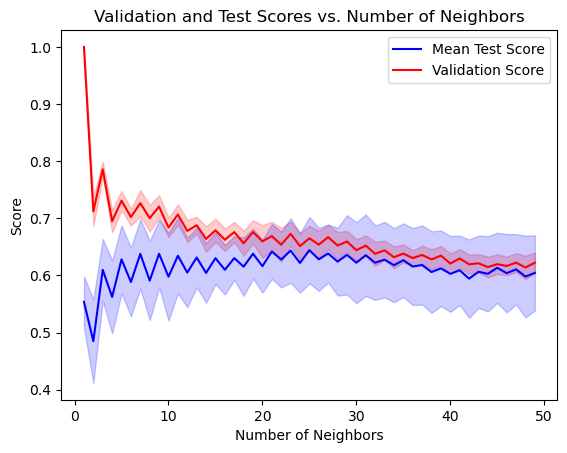

In [10]:
param = 'param_n_neighbors'
score_p = ['mean_test_f1', 'mean_train_f1']
std_p = ['std_test_f1', 'std_train_f1']
knn_results[param] = knn_results[param].astype(float)
fig, ax = plt.subplots()

ax.plot(knn_results[param], 
        knn_results[score_p[0]], 
        label='Mean Test Score',
        color = 'blue') 

ax.plot(knn_results[param], 
        knn_results[score_p[1]], 
        label='Validation Score', 
        color='red') 

ax.fill_between(knn_results[param], 
                (knn_results[score_p[1]] - knn_results[std_p[1]]), 
                (knn_results[score_p[1]] + knn_results[std_p[1]]), 
                color='red', alpha=0.2)

ax.fill_between(knn_results[param], 
                (knn_results[score_p[0]] - knn_results[std_p[0]]), 
                (knn_results[score_p[0]] + knn_results[std_p[0]]), 
                color='blue', alpha=0.2)
 
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Score')
ax.set_title('Validation and Test Scores vs. Number of Neighbors')

ax.legend()

plt.show()

Recall: 0.4151
Precision: 0.7097
F1 Score: 0.5238
Accuracy: 0.7386


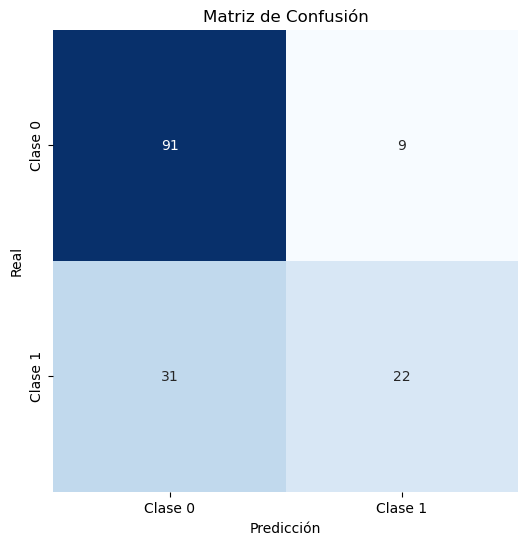

In [11]:
knn_pred = knn_grid.predict(X_test)
conf_matrix(y_test, knn_pred)

# RANDOM FOREST

In [12]:
rf_param = {
    'n_estimators': [50, 70, 90, 100, 200],
    'max_depth': range(1,9)
}

rf_results, rf, X_test_rf, y_test_rf, rf_metrics = training(RandomForestClassifier(), data, rf_param)


Los mejores parámetros son: {'max_depth': 8, 'n_estimators': 50}
El score de entrenamiento es: 0.9670303421868216
El mejor score es: 0.6641994623954344


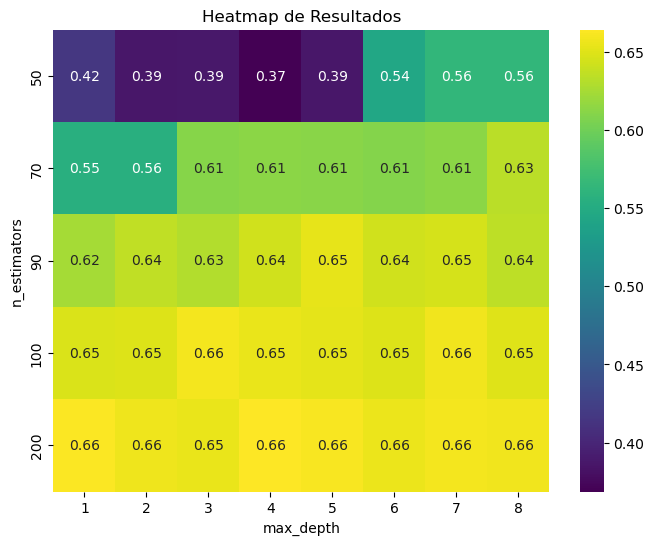

In [13]:
param_heat(rf_results, rf_param, 'max_depth', 'n_estimators')

Recall: 0.6226
Precision: 0.6111
F1 Score: 0.6168
Accuracy: 0.7320


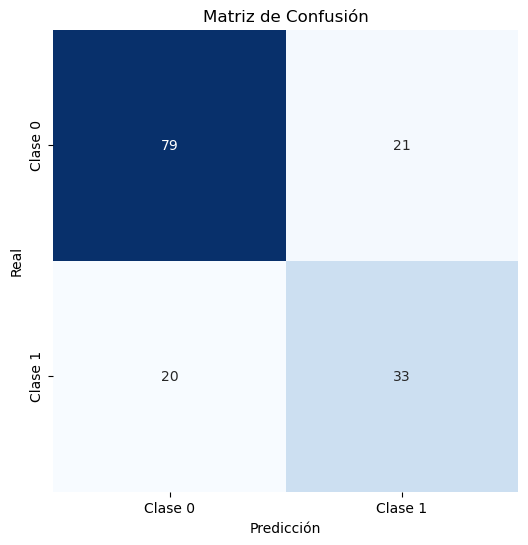

In [14]:
y_pred = rf.predict(X_test_rf)
conf_matrix(y_test_rf, y_pred)

# GRADIENT BOOSTING

In [15]:
gb_param = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': range(1,5),
    'learning_rate': [0.01, 0.1, 0.3, 0.001]#,
    #'subsample': [0.7, 1]
}
gb_results, gb, X_test, y_test, gb_metrics = training(GradientBoostingClassifier(), data, gb_param)

Los mejores parámetros son: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 10}
El score de entrenamiento es: 0.7960053908584839
El mejor score es: 0.6207500928982065


max_depth =  1


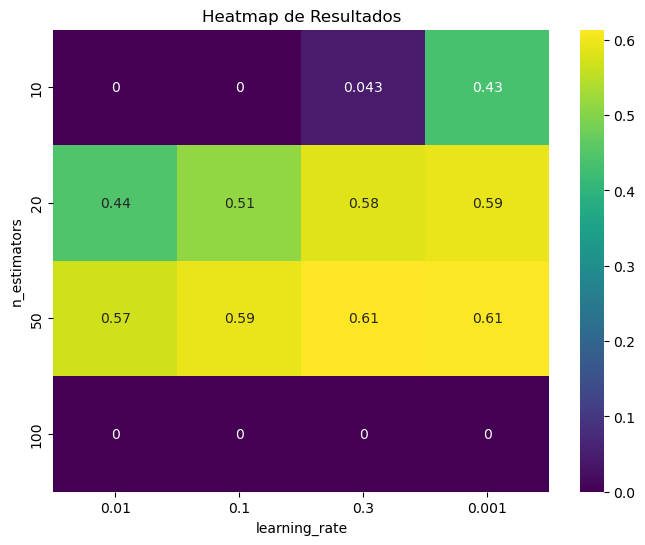

max_depth =  2


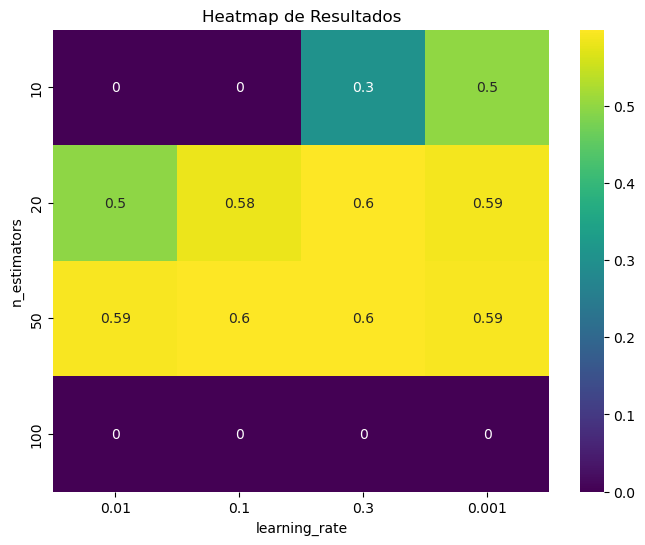

max_depth =  3


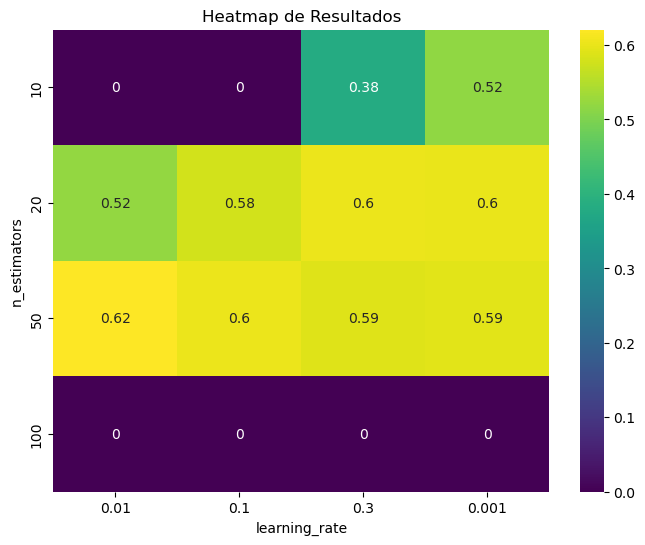

max_depth =  4


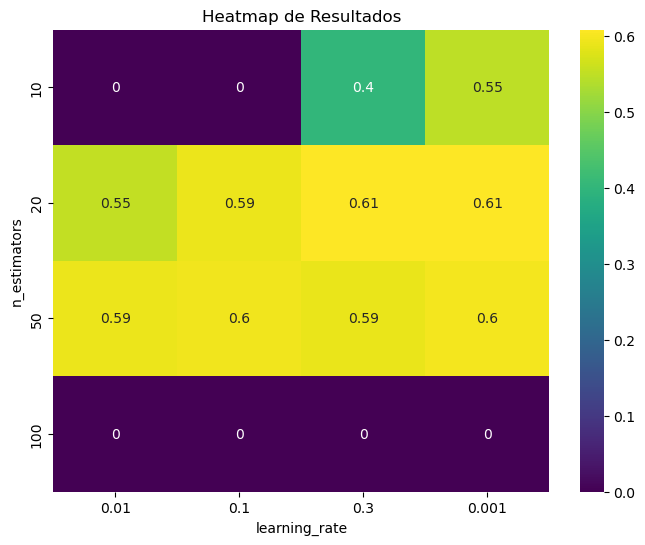

In [16]:
x_param = 'learning_rate'
z_param = 'n_estimators'
max_depth = 'param_max_depth'

for i in gb_results[max_depth].unique():
    subset = gb_results[gb_results[max_depth] == i]
    print('max_depth = ', i)
    param_heat(subset, gb_param, x_param, z_param)


Recall: 0.6415
Precision: 0.7234
F1 Score: 0.6800
Accuracy: 0.7908


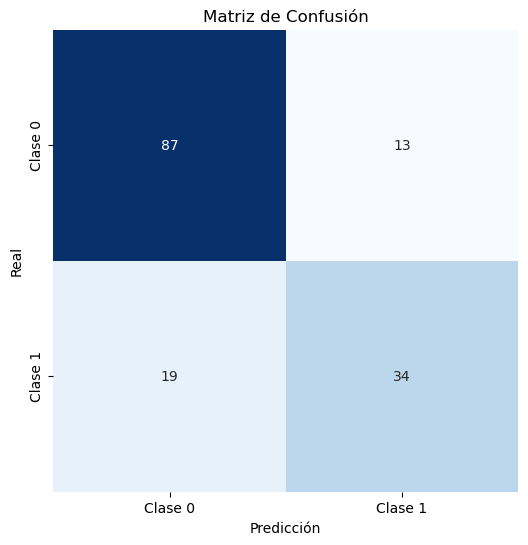

In [17]:
y_pred = gb.predict(X_test)
conf_matrix(y_test, y_pred)

# XGBOOST


In [18]:
xgb_params = {'max_depth' : range(2, 5),
              'learning_rate' : [0.3, 0.1, 0.03, 0.01],
                # 'subsample':[0.5, 0.6],
                # 'colsample_bytree': [0.5, 1],
                # 'reg_alpha': [0, 0.1, 1, 10],
                # 'reg_lambda': [0, 0.1, 1, 10],
                # 'gamma': [0, 0.1, 1, 10],
                'scale_pos_weight' : [1, 1.5, 2, 3]
    }

xgb_results, xgb, X_test, y_test, xgb_metrics = training(XGBClassifier(), data, xgb_params)

Los mejores parámetros son: {'learning_rate': 0.03, 'max_depth': 2, 'scale_pos_weight': 2}
El score de entrenamiento es: 0.7475018996015518
El mejor score es: 0.6860206620248103


Recall: 0.8679
Precision: 0.5897
F1 Score: 0.7023
Accuracy: 0.7451


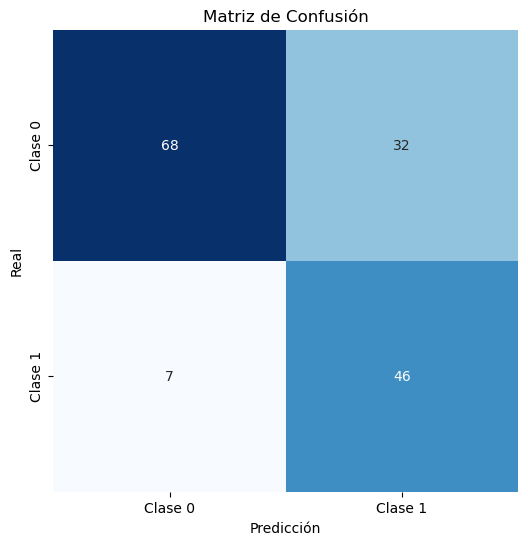

In [19]:
y_pred = xgb.best_estimator_.predict(X_test)
conf_matrix(y_test, y_pred)

Comparemos los resultados de cada modelo

In [20]:
metrics = pd.concat([knn_metrics,rf_metrics, gb_metrics, xgb_metrics])
metrics

,Mean Test Accuracy,Mean Test F1,Mean Test Precision,Mean Test Recall
KNeighborsClassifier,0.774184,0.644305,0.716827,0.591399
RandomForestClassifier,0.779626,0.664199,0.715322,0.627132
GradientBoostingClassifier,0.753987,0.620750,0.673169,0.579144
XGBClassifier,0.744649,0.686021,0.601549,0.801107


Ahora comparemos los resultados de cada modelo en diferentes separaciones de los datos 

In [21]:
Total_xgb = robust_model_evaluation(XGBClassifier(), data, xgb_params)
Total_knn = robust_model_evaluation(KNeighborsClassifier(), data, knn_params)
Total_rf = robust_model_evaluation(RandomForestClassifier(), data, rf_param)
Total_gb = robust_model_evaluation(GradientBoostingClassifier(), data, gb_param)
model_dfs = [Total_xgb, Total_rf, Total_knn, Total_gb]
model_names = ['XGBoost', 'RandomForest', 'KNeighbors', 'GradientBoosting']

results_summary = collect_model_averages(model_dfs, model_names)
results_summary

,valid accuracy,test accuracy,valid f1,test f1,valid recall,test recall,valid precision,test precision
XGBoost,0.765 ± 0.007,0.756 ± 0.031,0.702 ± 0.010,0.692 ± 0.039,0.794 ± 0.019,0.796 ± 0.090,0.632 ± 0.007,0.616 ± 0.038
RandomForest,0.773 ± 0.006,0.745 ± 0.017,0.647 ± 0.010,0.602 ± 0.061,0.601 ± 0.012,0.566 ± 0.105,0.707 ± 0.013,0.653 ± 0.020
KNeighbors,0.772 ± 0.007,0.740 ± 0.016,0.638 ± 0.015,0.595 ± 0.041,0.581 ± 0.027,0.558 ± 0.092,0.716 ± 0.022,0.650 ± 0.047
GradientBoosting,0.769 ± 0.010,0.748 ± 0.026,0.648 ± 0.015,0.614 ± 0.065,0.612 ± 0.020,0.589 ± 0.109,0.695 ± 0.017,0.654 ± 0.043


Como la categoría con mas nans es "Insulin" nos desharemos de ella para analizar si se puede desarrollar un modelo apropiado

In [23]:
data_ins = data.drop(['Insulin'], axis = 1)
Total_xgb_i = robust_model_evaluation(XGBClassifier(), data_ins, xgb_params)
Total_knn_i = robust_model_evaluation(KNeighborsClassifier(), data_ins, knn_params)
Total_rf_i = robust_model_evaluation(RandomForestClassifier(), data_ins, rf_param)
Total_gb_i = robust_model_evaluation(GradientBoostingClassifier(), data_ins, gb_param)

model_dfs_i = [Total_xgb_i, Total_rf_i, Total_knn_i, Total_gb_i]

results_summary_i = collect_model_averages(model_dfs_i, model_names)
results_summary_i

,valid accuracy,test accuracy,valid f1,test f1,valid recall,test recall,valid precision,test precision
XGBoost,0.756 ± 0.014,0.749 ± 0.015,0.698 ± 0.013,0.686 ± 0.019,0.809 ± 0.018,0.792 ± 0.072,0.617 ± 0.018,0.608 ± 0.026
RandomForest,0.777 ± 0.005,0.742 ± 0.012,0.650 ± 0.010,0.590 ± 0.039,0.601 ± 0.020,0.540 ± 0.083,0.716 ± 0.016,0.662 ± 0.038
KNeighbors,0.775 ± 0.011,0.753 ± 0.017,0.633 ± 0.018,0.604 ± 0.027,0.560 ± 0.030,0.547 ± 0.074,0.740 ± 0.037,0.688 ± 0.068
GradientBoosting,0.773 ± 0.007,0.752 ± 0.015,0.643 ± 0.016,0.605 ± 0.060,0.591 ± 0.024,0.558 ± 0.102,0.713 ± 0.013,0.671 ± 0.011
